In [1]:
!pip install nibabel

In [90]:
import nibabel as nib
import keras
import numpy as np
import os
from keras.layers import *
from keras.models import *
from keras.optimizers import *

TEST_PATH = "/kaggle/input/testing/"
TRAIN_PATH = "/kaggle/input/training/"
CHECKPOINT_PATH = "/kaggle/working/checkpoint"

In [71]:
gt = []
data = []

for i in range(1,11):
    groundtruth = nib.load(TRAIN_PATH+"subject-"+str(i)+"-label.hdr").get_fdata()
    
    
    t1 = nib.load(TRAIN_PATH+"subject-"+str(i)+"-T1.hdr").get_fdata()
    t2 = nib.load(TRAIN_PATH+"subject-"+str(i)+"-T2.hdr").get_fdata()
    
    gt0 = groundtruth == 0
    gt1 = groundtruth == 10
    gt2 = groundtruth == 150
    gt3 = groundtruth == 250

    gt.append(np.stack((gt0,gt1,gt2,gt3),axis=-1).squeeze())
    data.append(np.stack((t1,t2),axis=-1).squeeze())
    
    
gt = np.array(gt)#.astype(np.float32)
data = np.array(data)#.astype(np.float32)

min_val = data.min()
max_val = data.max()
data = (data - min_val) / (max_val - min_val)

In [72]:
print(gt.shape)
print(data.shape)

(10, 144, 192, 256, 4)
(10, 144, 192, 256, 2)


In [85]:
import random

class SlicesGenerator(keras.utils.Sequence):
    def __init__(self, data, gt, batch_size=8):
        self.data = data # input
        self.gt = gt # ground true
        self.batch_size = batch_size
        
    def __len__(self): # how many batches for each period ?
        shape = data.shape
        return int(1024 / (self.batch_size // 8))
    
    def __getitem__(self,idx): 
        # return a batch of data/gound true
        batch_x, batch_y = [], []
        
        i = 0
        while i < self.batch_size:
            idx = random.randint(0,len(self.data)-1)
            sub_idx = random.randint(0, 255)
            if not np.all(self.gt[idx, :, :, sub_idx] == [True, False, False, False]):
                # Generate a random rotation angle (0, 90, 180, or 270 degrees)
                angle = random.choice([0, 90, 180, 270])
                
                data_slice = self.data[idx, :, :, sub_idx]
                gt_slice = self.gt[idx, :, :, sub_idx]
                
                # Apply the same rotation angle to both data and gt slices
                #data_slice = np.rot90(data_slice, k=angle // 90)
                #gt_slice = np.rot90(gt_slice, k=angle // 90)
                
                # Apply random horizontal flip
                if random.choice([True, False]):
                    axis = random.choice([0, 1])
                    data_slice = np.flip(data_slice, axis=axis)
                    gt_slice = np.flip(gt_slice, axis=axis)
                
                batch_x.append(data_slice)
                batch_y.append(gt_slice)
                i += 1
        
        return np.array(batch_x), np.array(batch_y)

In [86]:
generator = SlicesGenerator(data,gt)
print(generator.__getitem__(2)[0].shape)
print(generator.__getitem__(2)[1].shape)

(8, 144, 192, 2)
(8, 144, 192, 4)


In [82]:
### Create the model ###
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten


def first_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (2,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

model = first_model((144,192), 4)
print("Nombre de couches : ", len(model.layers))
model.build(input_shape=(144,192,2))
model.summary()

Nombre de couches :  72
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 192, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 72, 96, 32)   608         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 72, 96, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                      

In [93]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

def scheduler(epoch, lr):
    if epoch < 10:
         return lr
    else:
        return lr * tf.math.exp(-0.1)
    
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [94]:
model.compile(loss='binary_crossentropy',
          optimizer='adam',      
          metrics=['accuracy'])

BATCH_SIZE = 16
train_gen = SlicesGenerator(data[0:8], gt[0:8], batch_size = BATCH_SIZE)
val_gen = SlicesGenerator(data[8:10], gt[8:10], batch_size = BATCH_SIZE)
nb_iter = 25
history = model.fit(train_gen, validation_data=val_gen, epochs=nb_iter, callbacks=[checkpoint, LearningRateScheduler])

Epoch 1/25
512/512 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9682
Epoch 1: val_accuracy improved from -inf to 0.92039, saving model to /kaggle/working/checkpoint
512/512 [==============================] - 114s 193ms/step - loss: 0.0378 - accuracy: 0.9682 - val_loss: 0.1080 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 2/25
512/512 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9704
Epoch 2: val_accuracy improved from 0.92039 to 0.92075, saving model to /kaggle/working/checkpoint
512/512 [==============================] - 99s 194ms/step - loss: 0.0351 - accuracy: 0.9704 - val_loss: 0.1146 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 3/25
512/512 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9722
Epoch 3: val_accuracy did not improve from 0.92075
512/512 [==============================] - 88s 172ms/step - loss: 0.0331 - accuracy: 0.9722 - val_loss: 0.1216 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 4/25
512/512 [====

1/1 [==============================] - 0s 24ms/step


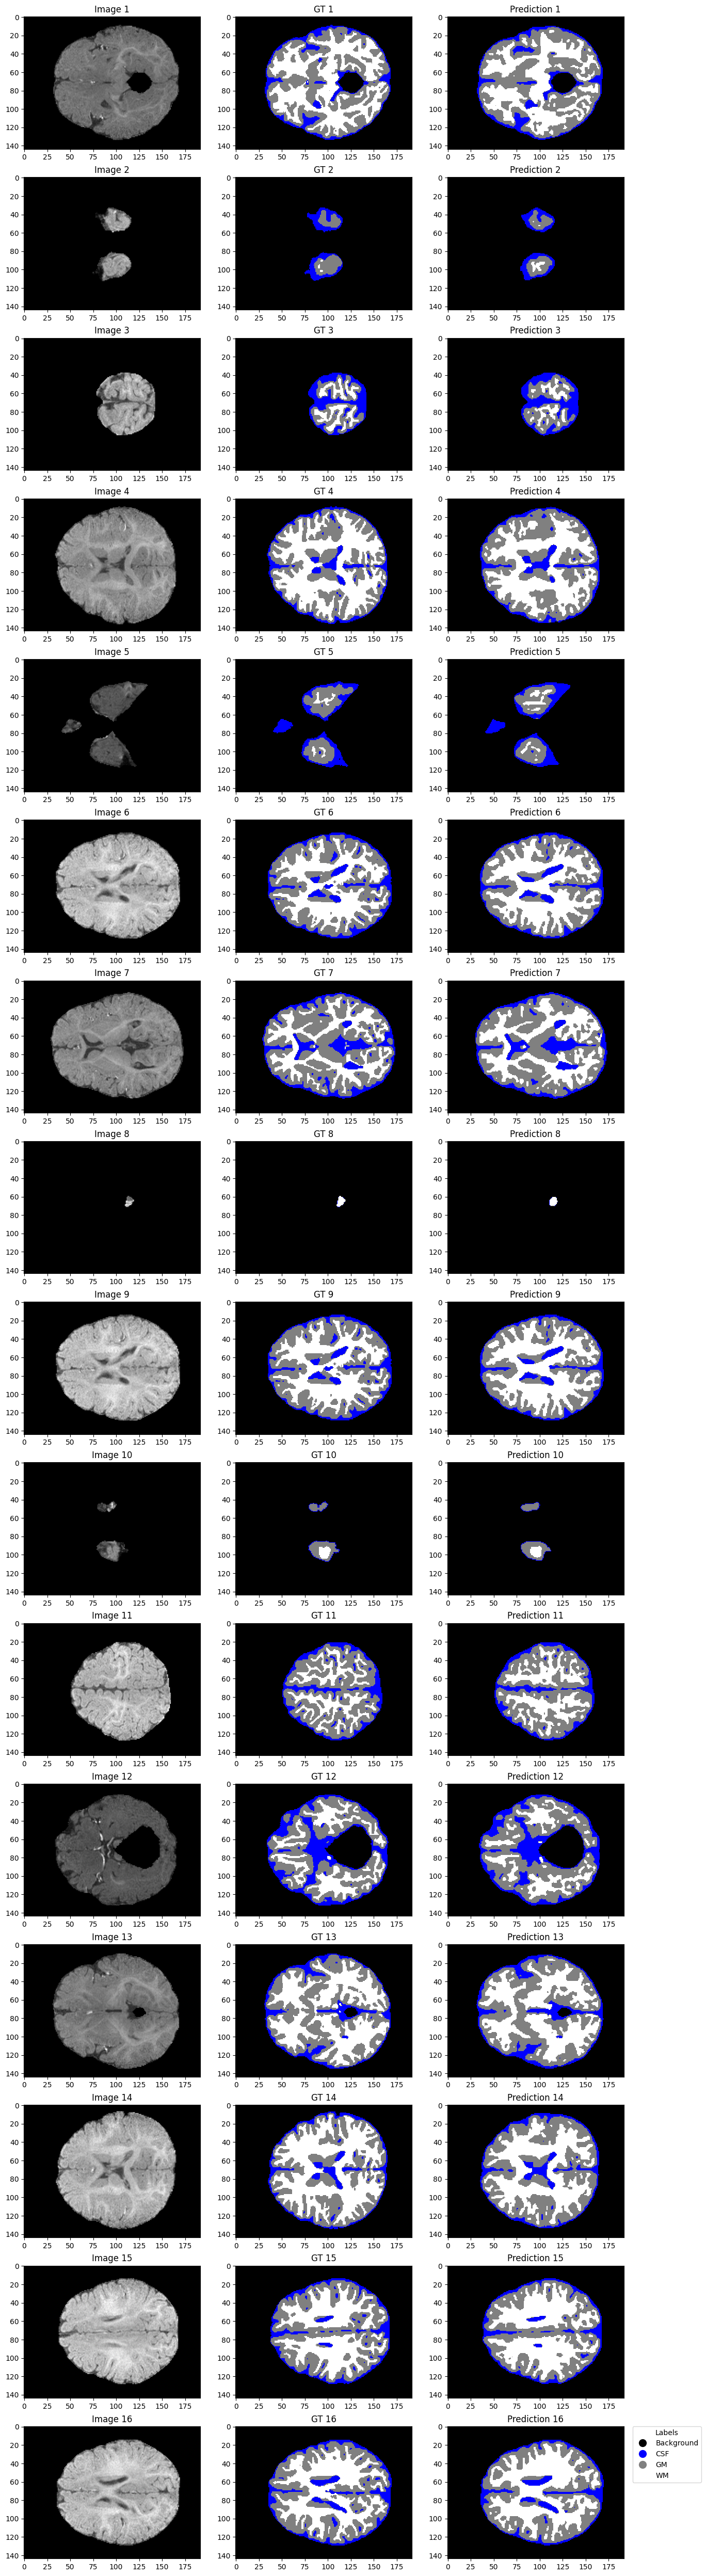

In [102]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


#model = tf.keras.models.load_model(CHECKPOINT_PATH)
x_val, y_val = val_gen.__getitem__(0)
predictions = model.predict(x_val)


colors = ['black', 'blue', 'gray', 'white']
legend = ['Background', 'CSF', 'GM', 'WM']
cmap = mcolors.ListedColormap(colors)


num_images = x_val.shape[0]
plt.figure(figsize=(15, 4*num_images))

for i in range(num_images):
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(x_val[i, :, :, 0], cmap='gray')  
    plt.title(f'Image {i + 1}')

    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(np.argmax(y_val[i], axis=-1), cmap=cmap)
    plt.title(f'GT {i + 1}')

    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(np.argmax(predictions[i], axis=-1), cmap=cmap)
    plt.title(f'Prediction {i + 1}')

# Create a legend for the labels
patches = [plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=colors[i],
                    label=f"{legend[i]}")[0] for i in range(len(colors))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Labels")

plt.show()


In [124]:
test = []
j=0
for i in range(11,24):
    t1 = nib.load(TEST_PATH+"subject-"+str(i)+"-T1.hdr").get_fdata()
    t2 = nib.load(TEST_PATH+"subject-"+str(i)+"-T2.hdr").get_fdata()
    
    test.append(np.stack((t1,t2),axis=-1).squeeze())
    j+=1
    print(j)
print(len(test))
#test = np.array(data)

1
2
3
4
5
6
7
8
9
10
11
12
13
13


In [122]:
test.shape


(10, 144, 192, 256, 2)

In [126]:
def to_apply(a):
    idx = np.argmax(a)
    a = np.zeros_like(a)
    if idx == 0:
        return 0;
    if idx == 1:
        return 10
    if idx == 2:
        return 150
    if idx == 3:
        return 250

all_pred = []
for i in range(len(test)):
    img_to_pred = test[i]
    prediction = model.predict(img_to_pred.transpose((2,0,1,3)))
    all_pred.append(np.apply_along_axis(to_apply,-1,prediction))
!ls "/kaggle/working/"

8/8 [==============================] - 1s 34ms/step
checkpoint


In [132]:
#result = np.array(all_pred).transpose((0,3,1,2))
#result.shape
all_pred[0].transpose((1,2,0)).shape

(144, 192, 256)

In [136]:
data_dic = {f'subject-{i}':all_pred[i-11].transpose((1,2,0)).astype(np.uint8) for i in range(11, 24)}
np.savez("/kaggle/working/brain_YF.npz", **data_dic)

In [135]:
data_dic["subject-11"].dtype

dtype('int64')